In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitions/digit-recognizer/sample_submission.csv
/kaggle/input/competitions/digit-recognizer/train.csv
/kaggle/input/competitions/digit-recognizer/test.csv


In [2]:
data = pd.read_csv("/kaggle/input/competitions/digit-recognizer/train.csv")

In [3]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [6]:
data.shape

(42000, 785)

In [7]:
data = np.array(data)
m, n = data.shape

# shuffling data
np.random.shuffle(data)

In [8]:
#transposing data
data_test = data[0:1000].T
y_test = data_test[0]
X_test = data_test[1:]

data_train = data[1000:].T
y_train = data_train[0]
X_train = data_train[1:]


In [9]:
X_train.shape

(784, 41000)

In [10]:
y_train.size

41000

In [11]:
def RelU(Z):
    return np.maximum(0, Z)

def softmax(Z):
    Z = Z - np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    # (10, m)/(1, m), this is broadcasting

# Y is (41000, )
def one_hot(Y):
    one_hot_Y = np.zeros((10, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y

def derivative_RELU(Z):
    return Z > 0

def get_accuracy(Y_hat, Y):
    predictions = np.argmax(Y_hat, axis=0)
    return np.mean(predictions == Y)
    

In [12]:
# initialize the parameters
# weights and biases

# for this neural network we have 2 hidden layers each with 10 neurons
#step 1
def init_params():
    # each neuron will have 784 randomly assigned weights
    # subtract 0.5 to center them arnd 0
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

# step 2
def forward_propogation(W1, b1, W2, b2, X):
    Z1 = (W1 @ X) + b1 # (10, m) #matrix multiplication
    # apply activation function
    A1 = RelU(Z1) # (10, m) #elementary multiplication
    Z2 = (W2 @ A1) + b2 # (10, m)
    A2 = softmax(Z2) # (10, m)
    return Z1, A1, Z2, A2

def backward_propogation(X, Z1, A1, W2, Z2, A2, Y):
    m = Y.size
    one_hot_Y = one_hot(Y) # (10, m)
    # we are using categorical cross entropy(log loss)
    # dL/dz2 # with log loss and using softmax in the output layer, dl/dz2 becomes this
    dZ2 = A2 - one_hot_Y
    # dL/dw2  = dl/dz2 * dz2/dw2
    # (10, 10) = (10, m) * (m * 10)
    dW2 = (1/m) * (dZ2 @ A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    # dl/dw1 = dl/z2 dz2/da1 da1/dz1 dz1/dw1
    # (10, 784) = ((10, 10) * (10, m))  * (10, m) * (784, m).T
    dZ1 = (W2.T @ dZ2) * derivative_RELU(Z1)
    dW1 = (1/m) * (dZ1 @ X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - (alpha * dW1)
    W2 = W2 - (alpha * dW2)
    b1 = b1 - (alpha * db1)
    b2 = b2 - (alpha * db2)
    return W1, b1, W2, b2
    
def gradient_descent(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    accuracies = []
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_propogation(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_propogation(X, Z1, A1, W2, Z2, A2, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
         # a2 ki highest prob in every column and comparing that to Y
        accuracy = get_accuracy(A2, Y)
        accuracies.append(accuracy)
        
        print("iteration: ", i)
        print("accuracy: ", accuracy)

       
    return W1, b1, W2, b2, accuracies

In [13]:
normalized_x_train = X_train / 255 #each pixel is from 0 to 255
normalized_x_test = X_test / 255

In [14]:
W1, b1, W2, b2, accuracies = gradient_descent(normalized_x_train, y_train, 1000, 0.1)

iteration:  0
accuracy:  0.10463414634146341
iteration:  1
accuracy:  0.11273170731707317
iteration:  2
accuracy:  0.13217073170731708
iteration:  3
accuracy:  0.15221951219512195
iteration:  4
accuracy:  0.1700487804878049
iteration:  5
accuracy:  0.1862439024390244
iteration:  6
accuracy:  0.20139024390243904
iteration:  7
accuracy:  0.21460975609756097
iteration:  8
accuracy:  0.2273658536585366
iteration:  9
accuracy:  0.24053658536585365
iteration:  10
accuracy:  0.25229268292682927
iteration:  11
accuracy:  0.26382926829268294
iteration:  12
accuracy:  0.27358536585365856
iteration:  13
accuracy:  0.2839024390243902
iteration:  14
accuracy:  0.29417073170731706
iteration:  15
accuracy:  0.30329268292682926
iteration:  16
accuracy:  0.3131219512195122
iteration:  17
accuracy:  0.32258536585365855
iteration:  18
accuracy:  0.33319512195121953
iteration:  19
accuracy:  0.3432439024390244
iteration:  20
accuracy:  0.35236585365853657
iteration:  21
accuracy:  0.36160975609756096
iter

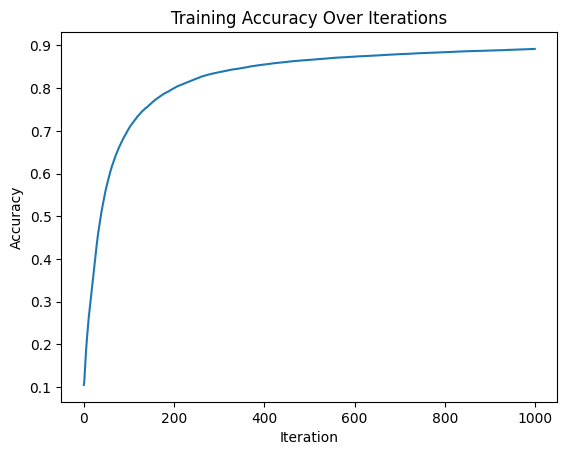

In [15]:
plt.figure()
plt.plot(accuracies)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Iterations")
plt.show()

In [16]:
# i have got my required weights 
# meaning the trained weights
Z1, A1, Z2, Y_hat = forward_propogation(W1, b1, W2, b2, normalized_x_test)

In [17]:
get_accuracy(Y_hat, y_test)

np.float64(0.881)

In [18]:
test_data = np.array(pd.read_csv("/kaggle/input/competitions/digit-recognizer/test.csv")).T / 255

In [19]:
Z1, A1, Z2, Y_hat = forward_propogation(W1, b1, W2, b2, test_data)

In [20]:
predictions = np.argmax(Y_hat, axis=0)

In [21]:
import pandas as pd

submission = pd.DataFrame({
    "ImageId": np.arange(1, len(predictions) + 1),
    "Label": predictions
})

In [22]:
submission.to_csv("submission.csv", index=False)